In [32]:
import sys
import random
import tensorflow as tf
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import itertools
import shutil as sh
from collections import defaultdict

tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
train_data = pd.read_csv('train.csv').drop(columns='PassengerId')

In [4]:
train_data['Age'].fillna(20, inplace=True)

In [24]:
bins = [0, 6, 23, 100]

pd.get_dummies(pd.cut(train_data['Age'], bins), prefix='Age')

,"Age_(0, 6]","Age_(6, 23]","Age_(23, 100]"
0,0,1,0
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1
5,0,1,0
6,0,0,1
7,1,0,0
8,0,0,1
9,0,1,0


In [19]:
def create_data():

    
    train_data = pd.read_csv('train.csv').drop(columns='PassengerId')
    test_data = pd.read_csv('test.csv').drop(columns='PassengerId')
    
    train_data['Married_female'] = train_data['Name'].apply(lambda x: 1 if x.find('Mrs') != -1 else 0)
    test_data['Married_female'] = test_data['Name'].apply(lambda x: 1 if x.find('Mrs') != -1 else 0)

    
    married_males = []
    
    for text in train_data['Name']:
        if text.find('Mrs.') < 0:
            continue
        words_list = text.split(', Mrs.')
        surname = words_list[0]
        second_word = words_list[1]
        words_list = second_word.split('(')
        name = words_list[0]
        if name == ' ':
            continue
        name = name.strip()
        surname = surname.strip()
        married_males.append(surname + ', Mr. ' + name)

    
    married_males_test = []

    for text in test_data['Name']:
        if text.find('Mrs.') < 0:
            continue
        words_list = text.split(', Mrs.')
        surname = words_list[0]
        second_word = words_list[1]
        words_list = second_word.split('(')
        name = words_list[0]
        if name == ' ':
            continue
        name = name.strip()
        surname = surname.strip()
        married_males_test.append(surname + ', Mr. ' + name)


    train_data['Married_male'] = train_data['Name'].apply(lambda x: 1 if x in married_males else 0)
    test_data['Married_male'] = test_data['Name'].apply(lambda x: 1 if x in married_males else 0)


    train_data['Young'] = train_data.apply(
        lambda x: 1 if x.Name[-1:] == 'J' or x.Name.find('Jr') >= 0 or 12 < x.Age <= 25 else 0, axis=1)

    test_data['Young'] = test_data.apply(
        lambda x: 1 if x.Name[-1:] == 'J' or x.Name.find('Jr') >= 0 or 12 < x.Age <= 25 else 0, axis=1)

    train_data['Age'] = train_data.apply(
        lambda x: 25 if np.isnan(x.Age) and x.Young == 1 else 40 if np.isnan(x.Age) else x.Age, axis=1)

    test_data['Age'] = test_data.apply(
        lambda x: 25 if np.isnan(x.Age) and x.Young == 1 else 40 if np.isnan(x.Age) else x.Age, axis=1)


    age_bins = [0, 6, 23, 62]
    pd.get_dummies(pd.cut(train_data['Age'], age_bins), prefix='Age')
    
    train_data.append(pd.get_dummies(pd.cut(train_data['Age'], age_bins), prefix='Age'), ignore_index=False, sort=False)
    test_data.append(pd.get_dummies(pd.cut(test_data['Age'], age_bins), prefix='Age'), ignore_index=False, sort=False)

    train_data.drop(columns='Age', inplace=True)
    test_data.drop(columns='Age', inplace=True)

    
    test_data['Fare'].fillna(0.0, inplace=True)


    mapping = {'female':1, 'male':0}
    train_data['Sex'].replace(to_replace=mapping, inplace=True)
    test_data['Sex'].replace(to_replace=mapping, inplace=True)


    train_data['Ticket'] = train_data.apply(lambda x: 'Reg' if x.Ticket.isnumeric() else x.Ticket, axis=1)
    test_data['Ticket'] = test_data.apply(lambda x: 'Reg' if x.Ticket.isnumeric() else x.Ticket, axis=1)


    train_data['Ticket'] = train_data.apply(lambda x: x.Ticket[:1], axis=1)
    test_data['Ticket'] = test_data.apply(lambda x: x.Ticket[:1], axis=1)


    train_data['Ticket'] = train_data.apply(lambda x: 'SCR' if x.Ticket in 'SCR' else x.Ticket, axis=1)
    test_data['Ticket'] = test_data.apply(lambda x: 'SCR' if x.Ticket in 'SCR' else x.Ticket, axis=1)


    dummy = pd.get_dummies(train_data['Ticket'], prefix='Ticket', prefix_sep='_')
    tickets = list(dummy)
    train_data[tickets] = dummy[tickets]


    dummy = pd.get_dummies(test_data['Ticket'], prefix='Ticket', prefix_sep='_')
    tickets = list(dummy)
    test_data[tickets] = dummy[tickets]


    train_data.drop(columns=['Name', 'Ticket'], inplace=True)
    test_data.drop(columns=['Name', 'Ticket'], inplace=True)


    train_data.dropna(axis=0, subset=['Embarked'], inplace=True)


    train_data.reset_index(drop=True, inplace=True)


    dummy = pd.get_dummies(train_data['Embarked'], prefix='Embark', prefix_sep='_')
    embark = list(dummy)
    train_data[embark] = dummy[embark]


    dummy = pd.get_dummies(test_data['Embarked'], prefix='Embark', prefix_sep='_')
    embark = list(dummy)
    test_data[embark] = dummy[embark]

    train_data.drop(columns='Embarked', inplace=True)
    test_data.drop(columns='Embarked', inplace=True)


    train_data['Cabin'].fillna('N', inplace=True)
    test_data['Cabin'].fillna('N', inplace=True)


    train_data['Cabin'] = train_data.apply(lambda x: x.Cabin[:1], axis=1)
    test_data['Cabin'] = test_data.apply(lambda x: x.Cabin[:1], axis=1)

    train_data['Cabin'] = train_data.apply(lambda x: 'EBD' if x.Cabin in 'EBD' else x.Cabin, axis=1)
    test_data['Cabin'] = test_data.apply(lambda x: 'EBD' if x.Cabin in 'EBD' else x.Cabin, axis=1)

    train_data['Cabin'] = train_data.apply(lambda x: 'AG' if x.Cabin in 'AG' else x.Cabin, axis=1)
    test_data['Cabin'] = test_data.apply(lambda x: 'AG' if x.Cabin in 'AG' else x.Cabin, axis=1)

    train_data['Cabin'] = train_data.apply(lambda x: 'CF' if x.Cabin in 'CF' else x.Cabin, axis=1)
    test_data['Cabin'] = test_data.apply(lambda x: 'CF' if x.Cabin in 'CF' else x.Cabin, axis=1)

    train_data['Cabin'] = train_data.apply(lambda x: 'N' if x.Cabin in 'TN' else x.Cabin, axis=1)
    test_data['Cabin'] = test_data.apply(lambda x: 'N' if x.Cabin in 'TN' else x.Cabin, axis=1)



    dummy = pd.get_dummies(train_data['Cabin'], prefix='Cabin', prefix_sep='_')
    cabins = list(dummy)
    train_data[cabins] = dummy[cabins]

    dummy = pd.get_dummies(test_data['Cabin'], prefix='Cabin', prefix_sep='_')
    cabins = list(dummy)
    test_data[cabins] = dummy[cabins]

    train_data.drop(columns='Cabin', inplace=True)
    test_data.drop(columns='Cabin', inplace=True)


    train_data['Fare'] = train_data.apply(lambda x: 'LOW' if x.Fare < PRICE_LOW else x.Fare, axis=1)
    train_data['Fare'] = train_data.apply(lambda x: 'MID_LOW' if isinstance(x.Fare, np.number) and x.Fare >= PRICE_LOW and x.Fare < PRICE_MID else x.Fare, axis=1)
    train_data['Fare'] = train_data.apply(lambda x: 'MID_HIGH' if isinstance(x.Fare, np.number) and x.Fare >= PRICE_MID and x.Fare < PRICE_HIGH else x.Fare, axis=1)
    train_data['Fare'] = train_data.apply(lambda x: 'HIGH' if isinstance(x.Fare, np.number) and x.Fare >= PRICE_HIGH else x.Fare, axis=1)

    test_data['Fare'] = test_data.apply(lambda x: 'LOW' if x.Fare < PRICE_LOW else x.Fare, axis=1)
    test_data['Fare'] = test_data.apply(lambda x: 'MID_LOW' if isinstance(x.Fare, np.number) and x.Fare >= PRICE_LOW and x.Fare < PRICE_MID else x.Fare, axis=1)
    test_data['Fare'] = test_data.apply(lambda x: 'MID_HIGH' if isinstance(x.Fare, np.number) and x.Fare >= PRICE_MID and x.Fare < PRICE_HIGH else x.Fare, axis=1)
    test_data['Fare'] = test_data.apply(lambda x: 'HIGH' if isinstance(x.Fare, np.number) and x.Fare >= PRICE_HIGH else x.Fare, axis=1)

    dummy = pd.get_dummies(train_data['Fare'], prefix='Fare', prefix_sep='_')
    fares = list(dummy)
    train_data[fares] = dummy[fares]

    dummy = pd.get_dummies(test_data['Fare'], prefix='Fare', prefix_sep='_')
    fares = list(dummy)
    test_data[fares] = dummy[fares]

    train_data.drop(columns=['Fare'], inplace=True)
    test_data.drop(columns=['Fare'], inplace=True)



    dummy = pd.get_dummies(train_data['Pclass'], prefix='Pclass', prefix_sep='_')
    _class = list(dummy)
    train_data[_class] = dummy[_class]

    dummy = pd.get_dummies(test_data['Pclass'], prefix='Pclass', prefix_sep='_')
    _class = list(dummy)
    test_data[_class] = dummy[_class]

    train_data.drop(columns=['Pclass'], inplace=True)
    test_data.drop(columns=['Pclass'], inplace=True)

    train_data.drop(columns=['Young'], inplace=True)
    test_data.drop(columns=['Young'], inplace=True)

    dummy = pd.get_dummies(train_data['Parch'], prefix='Parch', prefix_sep='_')
    parch = list(dummy)
    train_data[parch] = dummy[parch]
    train_data.drop(columns=['Parch'], inplace=True)

    dummy = pd.get_dummies(test_data['Parch'], prefix='Parch', prefix_sep='_')
    parch = list(dummy)
    test_data[parch] = dummy[parch]
    test_data.drop(columns=['Parch'], inplace=True)

    dummy = pd.get_dummies(train_data['SibSp'], prefix='SibSp', prefix_sep='_')
    sibsp = list(dummy)
    train_data[sibsp] = dummy[sibsp]
    train_data.drop(columns=['SibSp'], inplace=True)

    dummy = pd.get_dummies(test_data['SibSp'], prefix='SibSp', prefix_sep='_')
    sibsp = list(dummy)
    test_data[sibsp] = dummy[sibsp]
    test_data.drop(columns=['SibSp'], inplace=True)

    test_data.drop(columns='Parch_9', inplace=True)

    
    return train_data, test_data

In [20]:
def get_features(features='train_examples'):
    
    if features == 'train_examples':
        arr = np.asarray(train_data_final.drop(columns='Survived').iloc[:700,:], dtype=np.float32)
        arr = {'x': arr}
        
    elif features == 'train_labels':
        arr = np.asarray(train_data_final['Survived'][:700], dtype=np.int32)
        
    elif features == 'validate_examples':
        arr = np.asarray(train_data_final.drop(columns='Survived').iloc[700:,:], dtype=np.float32)
        arr = {'x': arr}
        
    elif features == 'validate_labels':
        arr = np.asarray(train_data_final['Survived'][700:], dtype=np.int32)
        
    elif features == 'test_examples':
        arr = np.asarray(test_data_final, dtype=np.float32)
        arr = {'x': arr}
        
    else:
        print('Unexpected features key: {}'.format(str(features)))
        sys.exit()
    
    return arr

In [21]:
def dnn_model_fn(features, labels, mode):
    
    reshape_layer_1 = tf.reshape(features['x'], [-1, features['x'].shape[1]])
    
    dense_layer_1 = tf.layers.dense(
        inputs=reshape_layer_1,
        units=100,
        activation=tf.nn.relu)
    
    dropout_layer_1 = tf.layers.dropout(
        inputs=dense_layer_1,
        rate=0.4,
        training=(mode == tf.estimator.ModeKeys.TRAIN))
    
    dense_layer_2 = tf.layers.dense(
        inputs=dropout_layer_1,
        units=100,
        activation=tf.nn.relu)
    
    logits_layer = tf.layers.dense(
        inputs=dense_layer_2,
        units=2)
    
    predictions = {'classes':tf.argmax(input=logits_layer, axis=1)}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    loss = tf.losses.sparse_softmax_cross_entropy(
        labels=labels,
        logits=logits_layer)
    
    accuracy = tf.metrics.accuracy(
        labels=labels,
        predictions = predictions['classes'],
        name='accu_op')
    
    tf.summary.histogram('accuracy', accuracy[1])
    
    if mode == tf.estimator.ModeKeys.TRAIN:
        train_optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_optimizer)
    
    # mode = EVAL
    eval_metric_ops = {'accuracy':accuracy}
    
    return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops = eval_metric_ops)

In [22]:
# directory to periodically save weights, biases, acc, loss
OUTDIR = './titanic_train_data'

dnn_classifier = tf.estimator.Estimator(model_fn=dnn_model_fn, model_dir=OUTDIR)

# call method to write train data to OUTDIR
#file_writer = tf.summary.FileWriter(OUTDIR)

In [23]:
def train_and_evaluate(estimator, epochs=1, global_steps=1, train_steps=100, del_dir=False):
    
    all_train_log = []
    all_validate_log = []

    for _ in range(epochs):

        for i in range(1, global_steps + 1, 1):

            estimator.train(input_fn=train_input_fn, steps=train_steps)

            train_log = estimator.evaluate(input_fn=eval_input_fn)
            print('STEP: {} of {}:'.format(i, global_steps))
            print('train:\t\tacc={:.3f}\tloss={:.3f}'.format(train_log['accuracy'], train_log['loss']))

            validate_log = estimator.evaluate(input_fn=validate_input_fn)
            print('valid:\t\tacc={:.3f}\tloss={:.3f}'.format(validate_log['accuracy'], validate_log['loss']))

            all_train_log.append(train_log)
            all_validate_log.append(validate_log)
    
    # DELETE MODEL DIR IF TRUE
    if del_dir:
        #print('\nDeleting folder \'{}\'\n'.format(OUTDIR))
        sh.rmtree(OUTDIR, ignore_errors=True)
            
    return all_train_log, all_validate_log

In [34]:
# TRAIN

GLOBAL_STEPS = 20
TRAIN_STEPS = 100
DEL_MODEL = True

PRICE_LOW = 10
PRICE_MID = 15
PRICE_HIGH = 80

all_train_acc = []
all_valid_acc = []
all_train_loss = []
all_valid_loss = []

if DEL_MODEL:
    sh.rmtree(OUTDIR, ignore_errors=True)

values = range(1, 10, 1)

for value in values:

    
    PRICE_LOW = value
    
    print('PRICE_LOW: {}\n'.format(value))
    
    train_data_final, test_data_final = create_data()

    
    
    train_input_fn = tf.estimator.inputs.numpy_input_fn(
        x=get_features(features='train_examples'),
        y=get_features(features='train_labels'),
        batch_size=5,
        num_epochs=1,
        shuffle=True)

    eval_input_fn = tf.estimator.inputs.numpy_input_fn(
        x=get_features(features='train_examples'),
        y=get_features(features='train_labels'),
        num_epochs=1,
        shuffle=False)

    validate_input_fn = tf.estimator.inputs.numpy_input_fn(
        x=get_features(features='validate_examples'),
        y=get_features(features='validate_labels'),
        num_epochs=1,
        shuffle=False)

    predict_input_fn = tf.estimator.inputs.numpy_input_fn(
        x=get_features(features='test_examples'),
        num_epochs=1,
        shuffle=False)
    
    
    
    train_log, validate_log = train_and_evaluate(
        dnn_classifier,
        global_steps=GLOBAL_STEPS,
        train_steps=TRAIN_STEPS,
        del_dir=DEL_MODEL)
    
    
    
    train_acc = [i['accuracy'] for i in train_log]
    valid_acc = [i['accuracy'] for i in validate_log]
    train_loss = [i['loss'] for i in train_log]
    valid_loss = [i['loss'] for i in validate_log]

    
    all_train_acc.append(np.mean(train_acc))
    all_valid_acc.append(np.mean(valid_acc))
    all_train_loss.append(np.mean(train_loss))
    all_valid_loss.append(np.mean(valid_loss))
        
    
    del(train_data_final)
    del(test_data_final)
    
    print('')

PRICE_LOW: 1

STEP: 1 of 20:
train:		acc=0.746	loss=0.517
valid:		acc=0.799	loss=0.465
STEP: 2 of 20:
train:		acc=0.801	loss=0.469
valid:		acc=0.810	loss=0.402
STEP: 3 of 20:
train:		acc=0.793	loss=0.445
valid:		acc=0.820	loss=0.392
STEP: 4 of 20:
train:		acc=0.821	loss=0.433
valid:		acc=0.831	loss=0.391
STEP: 5 of 20:
train:		acc=0.814	loss=0.425
valid:		acc=0.831	loss=0.386
STEP: 6 of 20:
train:		acc=0.821	loss=0.416
valid:		acc=0.825	loss=0.393
STEP: 7 of 20:
train:		acc=0.793	loss=0.450
valid:		acc=0.810	loss=0.421
STEP: 8 of 20:
train:		acc=0.827	loss=0.419
valid:		acc=0.831	loss=0.399
STEP: 9 of 20:
train:		acc=0.839	loss=0.400
valid:		acc=0.836	loss=0.393
STEP: 10 of 20:
train:		acc=0.836	loss=0.395
valid:		acc=0.836	loss=0.389
STEP: 11 of 20:
train:		acc=0.837	loss=0.392
valid:		acc=0.841	loss=0.392
STEP: 12 of 20:
train:		acc=0.836	loss=0.389
valid:		acc=0.841	loss=0.401
STEP: 13 of 20:
train:		acc=0.837	loss=0.396
valid:		acc=0.836	loss=0.425
STEP: 14 of 20:
train:		acc=0.844

valid:		acc=0.836	loss=0.365
STEP: 12 of 20:
train:		acc=0.836	loss=0.385
valid:		acc=0.836	loss=0.385
STEP: 13 of 20:
train:		acc=0.844	loss=0.376
valid:		acc=0.841	loss=0.370
STEP: 14 of 20:
train:		acc=0.837	loss=0.373
valid:		acc=0.841	loss=0.378
STEP: 15 of 20:
train:		acc=0.846	loss=0.372
valid:		acc=0.836	loss=0.378
STEP: 16 of 20:
train:		acc=0.844	loss=0.365
valid:		acc=0.836	loss=0.386
STEP: 17 of 20:
train:		acc=0.847	loss=0.360
valid:		acc=0.831	loss=0.386
STEP: 18 of 20:
train:		acc=0.849	loss=0.363
valid:		acc=0.836	loss=0.394
STEP: 19 of 20:
train:		acc=0.846	loss=0.356
valid:		acc=0.831	loss=0.393
STEP: 20 of 20:
train:		acc=0.851	loss=0.349
valid:		acc=0.825	loss=0.389

PRICE_LOW: 7

STEP: 1 of 20:
train:		acc=0.767	loss=0.502
valid:		acc=0.799	loss=0.448
STEP: 2 of 20:
train:		acc=0.803	loss=0.466
valid:		acc=0.825	loss=0.409
STEP: 3 of 20:
train:		acc=0.811	loss=0.446
valid:		acc=0.804	loss=0.398
STEP: 4 of 20:
train:		acc=0.814	loss=0.428
valid:		acc=0.825	loss=0.38

In [ ]:
# 32, 47, 54, 62

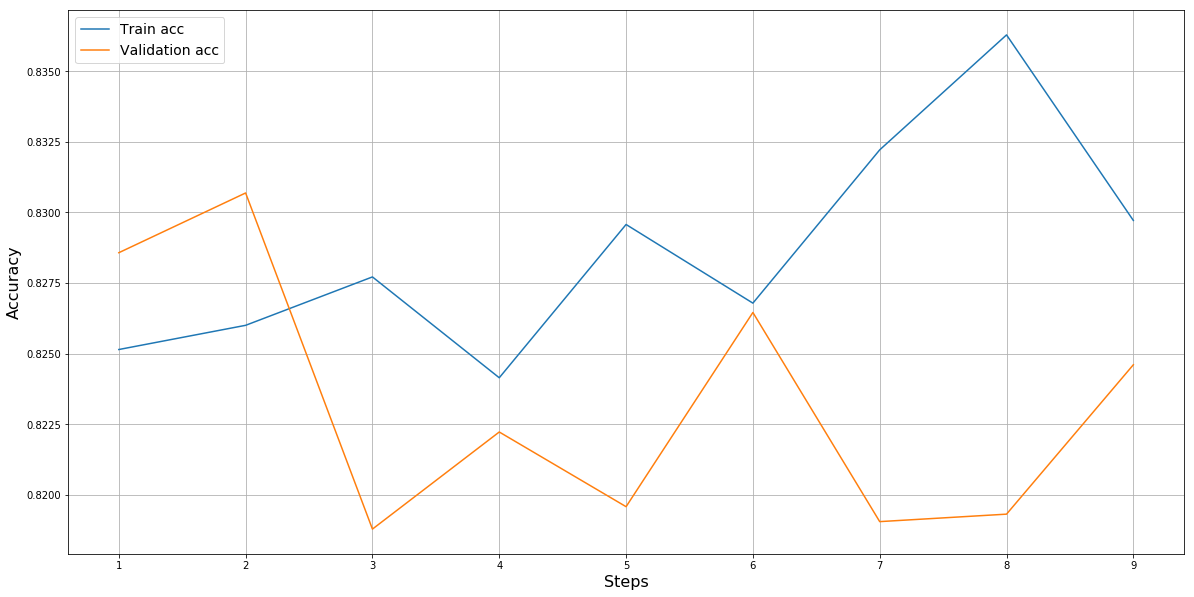

In [35]:
plt.figure(figsize=(20, 10))
plt.plot(all_train_acc)
plt.plot(all_valid_acc)
plt.ylabel('Accuracy', fontsize=16)
plt.xlabel('Steps', fontsize=16)
plt.xticks(range(0, 9, 1), range(1, 10, 1))
plt.grid()
plt.legend(['Train acc', 'Validation acc'], fontsize=14, loc='upper left')
plt.show()

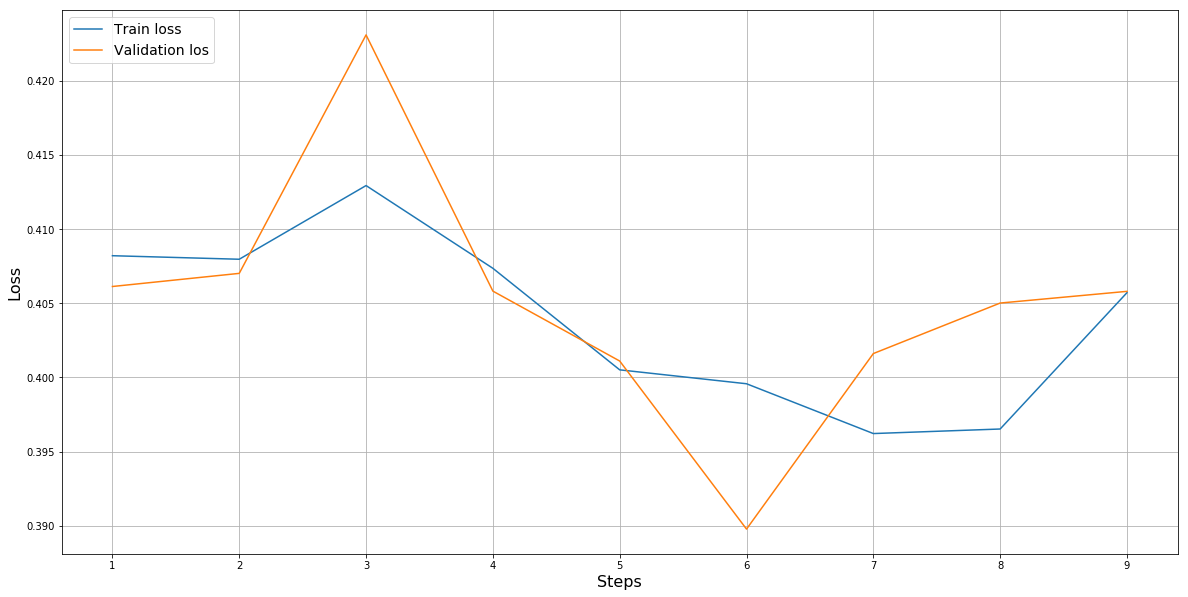

In [36]:
plt.figure(figsize=(20, 10))
plt.plot(all_train_loss)
plt.plot(all_valid_loss)
plt.xticks(range(0, 9, 1), range(1, 10, 1))
plt.ylabel('Loss', fontsize=16)
plt.xlabel('Steps', fontsize=16)
plt.legend(['Train loss', 'Validation los'], fontsize=14, loc='upper left')
plt.grid()
plt.show()

In [79]:
# create kaggle submission file
# in predict mode model returns generator
predict_generator = dnn_classifier.predict(input_fn=predict_input_fn)

# create list of dict like {class:class, probability:probability}
predict_dictlist = [next(predict_generator) for i in range(len(test_examples))]

# for kaggle we need only classes
classes = [predict_dictlist[item]['classes'] for item in range(len(predict_dictlist))]

# function to create pandas df
def create_mnist_submission_df(class_predictions, file_name):
    submission_df = pd.DataFrame()
    submission_df['PassengerId'] = pd.read_csv('test.csv')['PassengerId']
    submission_df['Survived'] = class_predictions
    submission_df.set_index('PassengerId', inplace=True)
    submission_df.to_csv(file_name)
    print('Saved predictions to ', file_name)

create_mnist_submission_df(classes, 'submission_titanic.csv')

Saved predictions to  submission_titanic.csv
